In [1]:
from torch.utils.data import DataLoader 
import torch
import matplotlib.pyplot as plt
from pyscf import gto, dft, scf 
from kspies import wy, zmp
from dpyscfl.scf import *
from dpyscfl.net import *
from dpyscfl.utils import *
import os, shutil
from ase import Atoms
from ase.io import read, write

In [2]:
#xcdiff
model = torch.jit.load('/home/awills/Documents/Research/xcdiff/models/final/log_mgga_reaction2/MGGA_REACTION2/xc')

In [10]:
nel = torch.Tensor([np.nan])
bool(torch.isnan(nel))

True

In [3]:
model.

RecursiveScriptModule(
  original_name=XC
  (heg_model): RecursiveScriptModule(original_name=LDA_X)
  (pw_model): RecursiveScriptModule(original_name=PW_C)
  (grid_models): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=XC_L
      (net): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Linear)
        (1): RecursiveScriptModule(original_name=GELU)
        (2): RecursiveScriptModule(original_name=Linear)
        (3): RecursiveScriptModule(original_name=GELU)
        (4): RecursiveScriptModule(original_name=Linear)
        (5): RecursiveScriptModule(original_name=GELU)
        (6): RecursiveScriptModule(original_name=Linear)
      )
      (tanh): RecursiveScriptModule(original_name=Tanh)
      (sig): RecursiveScriptModule(original_name=Sigmoid)
      (lobf): RecursiveScriptModule(
        original_name=LOB
        (sig): RecursiveScriptModule(original_name=Sigmoid)
      )
   

In [60]:
#to generate fractional results
def mkfracdir(fs, basedir, chargedir, newdir, charge=1):
    atomsbp = read(os.path.join(basedir, 'results.traj'), ":")
    atomscp = read(os.path.join(chargedir, 'results.traj'), ':')
    for cat in atomscp:
        cat.info['charge']=charge
    basecharged = atomsbp+atomscp
    if not type(fs) == list:
        fs = [fs]
    for f in fs:
        for iat, atom in enumerate(atomsbp):
            newAtom = atom.copy()
            newAtom.calc = atom.calc
            newAtom.info['fractional'] = f
            newAtom.info['baseRef'] = basedir
            newAtom.info['chargeRef'] = chargedir
            newAtom.info['baseidx'] = iat
            basecharged.append(newAtom)
    
    try:
        os.mkdir(newdir)
    except:
        pass
    write(os.path.join(newdir, 'results.traj'), basecharged)
    idx = 0
    for iat, atom in enumerate(atomsbp):
        idx_at = '{}_{}'.format(idx, atom.get_chemical_formula())
        iat_at = '{}_{}'.format(iat, atom.get_chemical_formula())
        dmp = os.path.join(basedir, iat_at+".dm.npy")
        mocp = os.path.join(basedir, iat_at+".mo_coeff.npy")
        moop = os.path.join(basedir, iat_at+".mo_occ.npy")
        ndmp = os.path.join(newdir, idx_at+".dm.npy")
        nmocp = os.path.join(newdir, idx_at+".mo_coeff.npy")
        nmoop = os.path.join(newdir, idx_at+".mo_occ.npy")
        shutil.copy2(dmp, ndmp)
        shutil.copy2(mocp, nmocp)
        shutil.copy2(moop, nmoop)
        idx+=1
    for iat, atom in enumerate(atomscp):
        idx_at = '{}_{}'.format(idx, atom.get_chemical_formula())
        iat_at = '{}_{}'.format(iat, atom.get_chemical_formula())
        dmp = os.path.join(basedir, iat_at+".dm.npy")
        mocp = os.path.join(basedir, iat_at+".mo_coeff.npy")
        moop = os.path.join(basedir, iat_at+".mo_occ.npy")
        ndmp = os.path.join(newdir, idx_at+".dm.npy")
        nmocp = os.path.join(newdir, idx_at+".mo_coeff.npy")
        nmoop = os.path.join(newdir, idx_at+".mo_occ.npy")
        shutil.copy2(dmp, ndmp)
        shutil.copy2(mocp, nmocp)
        shutil.copy2(moop, nmoop)
        idx+=1
    

In [61]:
bdir='/home/awills/Documents/Research/swxcd/aegis/fc0'
cdir='/home/awills/Documents/Research/swxcd/aegis/fcp'
ndir='/home/awills/Documents/Research/swxcd/aegis/fc0fcp'
mkfracdir(fs=0.5, basedir=bdir, chargedir=cdir, newdir=ndir)

In [62]:
tst = read(ndir+'/results.traj', ':')

In [63]:
[i.info for i in tst]

[{'hydrogen': True},
 {'helium': True},
 {'lithium': True},
 {'beryllium': True},
 {'boron': True},
 {'carbon': True},
 {'nitrogen': True},
 {'oxygen': True},
 {'fluorine': True},
 {'neon': True},
 {'sodium': True},
 {'magnesium': True},
 {'aluminum': True},
 {'silicon': True},
 {'phosphorous': True},
 {'sulfur': True},
 {'chlorine': True},
 {'argon': True},
 {'hydrogen': True, 'charge': 1},
 {'helium': True, 'charge': 1},
 {'lithium': True, 'charge': 1},
 {'beryllium': True, 'charge': 1},
 {'boron': True, 'charge': 1},
 {'carbon': True, 'charge': 1},
 {'nitrogen': True, 'charge': 1},
 {'oxygen': True, 'charge': 1},
 {'fluorine': True, 'charge': 1},
 {'neon': True, 'charge': 1},
 {'sodium': True, 'charge': 1},
 {'magnesium': True, 'charge': 1},
 {'aluminum': True, 'charge': 1},
 {'silicon': True, 'charge': 1},
 {'phosphorous': True, 'charge': 1},
 {'sulfur': True, 'charge': 1},
 {'chlorine': True, 'charge': 1},
 {'argon': True, 'charge': 1},
 {'hydrogen': True,
  'fractional': 0.5,
  '

# General Exploration of Things

In [3]:
fc0 = read('/home/awills/Documents/Research/swxcd/aegis/fc0/results.traj', ':')
moldct = ase_traj_to_mol(fc0)
mfdct = {key:gen_mf_mol(mol, xc='SCAN', grid_level=1)[0] for key,mol in moldct.items()}
for key,mf in mfdct.items():
    print(key)
    mf.max_cycle = 500
    mf.kernel()

Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED: <function UKS at 0x7f442b6179e0>
Building grids...
METHOD GENERATED: <function RKS at 0x7f442b5efd40>
Building grids...
METHOD GENERATED

In [4]:
mats = [get_datapoint(moldct[key], mfdct[key], dfit=True) for key in mfdct.keys()]
mats = {key:[dct[key] for dct in mats] for key in mats[0].keys()}
E_target = torch.Tensor(mats['e_base'])

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/pyscf/gto/moleintor.py:259: UserWarning: Function int4c1e_sph not found.  Set its comp to 1
  warnings.warn('Function %s not found.  Set its comp to 1' % intor_name)


In [8]:
dset = Dataset(**mats)
dloader = DataLoader(dset, batch_size = 1)
#inputs = next(iter(dloader)) # *
xc = XC(grid_models = [], heg_mult=True, pw_mult=True, level=1, exx_a=None)
alpha_init = 0.8
alpha = torch.nn.Parameter(torch.Tensor([alpha_init]))
#dscf = SCF(alpha=alpha, nsteps=10, xc=xc, device='cpu', exx=False)
dscf = get_scf(xctype='GGA', DEVICE='cuda')
diff = True
for name, param in dscf.named_parameters():
    param.requires_grad = diff
    print(name)
    print(param)
optimizer = torch.optim.Adam(dscf.parameters(), lr=0.01)
loss = torch.nn.MSELoss()

FREEC False
get_veff.model.grid_models.0.net.0.weight
Parameter containing:
tensor([[ 0.7129],
        [ 0.4597],
        [-0.0395],
        [ 0.8341],
        [ 0.8149],
        [ 0.7994],
        [ 0.2239],
        [ 0.8370],
        [ 0.5003],
        [-0.5867],
        [ 0.7752],
        [ 0.6802],
        [-0.2089],
        [-0.8322],
        [ 0.8005],
        [ 0.2637]], requires_grad=True)
get_veff.model.grid_models.0.net.0.bias
Parameter containing:
tensor([ 0.9437,  0.7395, -0.6417, -0.8677,  0.6172,  0.2299, -0.4634,  0.2773,
        -0.9441,  0.7391,  0.4866, -0.5730, -0.3234, -0.5353, -0.6870,  0.7592],
       requires_grad=True)
get_veff.model.grid_models.0.net.2.weight
Parameter containing:
tensor([[-6.2199e-02, -2.3068e-01,  1.2678e-01, -5.2871e-02,  2.1564e-01,
         -5.8237e-02, -7.0006e-02, -2.0120e-01, -1.7729e-01, -7.2564e-02,
          1.1545e-01,  2.1628e-01, -2.3860e-01, -1.0478e-01, -1.3672e-01,
          7.9309e-02],
        [ 1.9635e-01, -7.3907e-02,  1.40

In [7]:
dscf.named_parameters

<bound method Module.named_parameters of SCF(
  (get_veff): get_veff(
    (model): XC(
      (heg_model): LDA_X()
      (pw_model): PW_C()
      (grid_models): ModuleList(
        (0): X_L(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
            (6): Linear(in_features=16, out_features=1, bias=True)
          )
          (tanh): Tanh()
          (lobf): LOB(
            (sig): Sigmoid()
          )
        )
        (1): C_L(
          (net): Sequential(
            (0): Linear(in_features=3, out_features=16, bias=True)
            (1): GELU()
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): GELU()
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): GELU()
      

In [ ]:
for step in range(10):
    print(step)
    E_pred = []
    i=0
    fails = []
    for data in dloader:
        print('MOLECULE: {}'.format(list(moldct.keys())[i]))
        try:
            output = dscf.forward(*data)
            E_pred.append(output['E'][-1])
        except RuntimeError:
            print('fail')
            fails.append(i)
        i+=1
    E_pred = torch.stack(E_pred)
    E_ref = torch.Tensor([E_target[i] for i in range(len(E_target)) if i not in fails])
    lossv = loss(E_pred, E_ref)
    print(lossv)
    print("Zeroing Gradient")
    optimizer.zero_grad()
    print("Loss Backprop")
    lossv.backward()
    print("Updating Parameters")
    optimizer.step()


0
MOLECULE: H


/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/dpyscfl/scf.py:114: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2524.)
  e, c = torch.symeig(contract('ij,...jk,kl->...il',s_chol, h, s_chol.T), eigenvectors=True,upper=False)


MOLECULE: He
fail
MOLECULE: Li
MOLECULE: Be
MOLECULE: B
MOLECULE: C
MOLECULE: N
MOLECULE: O
MOLECULE: F
MOLECULE: Ne
MOLECULE: Na
MOLECULE: Mg
MOLECULE: Al
MOLECULE: Si
MOLECULE: P
MOLECULE: S
MOLECULE: Cl
MOLECULE: Ar
tensor(0.5163, grad_fn=<MseLossBackward0>)
Zeroing Gradient
Loss Backprop
Updating Parameters
1
MOLECULE: H
MOLECULE: He
fail
MOLECULE: Li
MOLECULE: Be
MOLECULE: B
MOLECULE: C
MOLECULE: N
MOLECULE: O
MOLECULE: F
MOLECULE: Ne
MOLECULE: Na
MOLECULE: Mg
MOLECULE: Al
MOLECULE: Si
MOLECULE: P
MOLECULE: S
MOLECULE: Cl
MOLECULE: Ar
tensor(0.5163, grad_fn=<MseLossBackward0>)
Zeroing Gradient
Loss Backprop
Updating Parameters
2
MOLECULE: H
MOLECULE: He
fail
MOLECULE: Li
MOLECULE: Be


In [63]:
dscf.parameters

<bound method Module.parameters of SCF(
  (get_veff): get_veff(
    (model): XC(
      (heg_model): LDA_X()
      (pw_model): PW_C()
    )
  )
  (eig): eig()
  (energy_tot): energy_tot()
  (make_rdm1): make_rdm1()
  (xc): XC(
    (heg_model): LDA_X()
    (pw_model): PW_C()
  )
)>

In [44]:
torch.stack(E_pred)

tensor([-4.7855e-01, -7.3415e+00, -1.4444e+01, -2.4351e+01, -5.4069e+01,
        -9.9096e+01, -1.2821e+02, -1.6143e+02, -1.9912e+02, -2.4131e+02,
        -3.3996e+02, -5.2592e+02], grad_fn=<StackBackward0>)

In [41]:
fails

[1, 5, 7, 13, 15, 16]

In [7]:
traj = read('/home/awills/Documents/Research/xcdiff/data/haunschild_pbe.traj', ':')

In [3]:
[(i.get_chemical_formula(), i.info) for i in traj]
mols = [gto.M(atom=[[ispec,ipos] for ispec,ipos in zip(iat.get_chemical_formula(), iat.positions)], spin=None, charge=0) for iat in traj[:2]]

In [4]:
mols[0].spin

1

# KSPies for Wu-Yang Decomposition, Fractional Charge Generation

In [14]:
mol = gto.M(atom='Na 0 0 0', basis='3-21G', spin=None)
molp = gto.M(atom='Na 0 0 0', basis='3-21G', charge=1, spin=None)
molh = gto.M(atom='Na 0 0 0', basis='3-21G', charge=0.5, spin=None)
mf = scf.HF(mol)
mfp = scf.HF(molp)
print(mf, mfp)
mf.kernel()
mfp.kernel()
e0 = mf.energy_tot()
ep = mfp.energy_tot()
dm = mf.make_rdm1()
dmp = mfp.make_rdm1()
print(dm.shape, dmp.shape)
wy0 = wy.UWY(mol, dm)
wyp = wy.RWY(molp, dmp)
#wy0.wyscf()
#wyp.wyscf()
wyh = wy.UWY(mol, (1-0.5)*dm+0.5*dmp )
wyh.wyscf()
wyh.info()

#wyh = zmp.UZMP(mol, (1-0.5)*dm+0.5*dmp )
#for l in [ 8, 16, 32, 64, 128, 256, 512 ]:
#    wyh.level_shift = l*0.1
#    wyh.zscf(l)
#    print(wyh.converged)
#wy0.info()
#wyp.info()
#dmwy = wy0.dm
#dmwyp = wyp.dm
#print(dmwy.shape, dmwyp.shape)


WARN: Found fractional number of electrons 10.500000. Round it to 10

<pyscf.scf.uhf.UHF object at 0x7faab0c09450> <pyscf.scf.hf.RHF object at 0x7faac3173890>
converged SCF energy = -160.854064685781  <S^2> = 0.75003623  2S+1 = 2.0000362
converged SCF energy = -160.6737462472
(2, 13, 13) (13, 13)
 *****Optimization Failed*****
      after 5200 iterations 
func_value : -152193126.61023265
max_grad   :      3.28860071
(2, 13, 13) (13, 13)


In [26]:
ind = np.where(wyh.mo_occ[0]-wyh.mo_occ[1])
wyh.mo_occ[1, ind] = 0.5
wyh.mo_occ
wyh.wyscf()
mol.intor??

In [29]:
print(mol.intor('int1e_kin').sum())
print(molp.intor('int1e_kin').sum())

74.7851944955926
74.7851944955926


In [7]:
mf.mo_occ, mfp.mo_occ, wyh.mo_occ

(array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [31]:
mf.mo_energy.shape, mfp.mo_energy.shape

((2, 13), (13,))

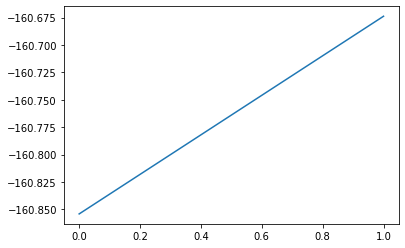

In [9]:
def fractional_energy(e0, ec, f, zero=False):
    return (1-f)*e0 + f*ec
def fractional_dm(dm0, dmc, f):
    return (1-f)*dm0 + f*dmc
f = plt.figure()
ax = f.add_subplot(111)
fs = np.linspace(0, 1, 100)
ax.plot(fs, fractional_energy(e0, ep, fs))

In [52]:
wyh = wy.UWY(mol, 0.5*dm+0.5*dmp)
wyh.wyscf()
wyh.info()

****Optimization Completed****
      after 3 scf cycles 
      and 8 iterations 
max(ddm)   :      0.00000095
func_value :   -160.26527030
max_grad   :      0.00000039


### 1. Define the xc model

Here we use a simple LDA model (`level = 1`), by choosing `heg_mult = True` (for homogeneous electron gas exchange) and `pw_mult = True` (for Perdew Wang HEG correlation), without any enhancement factors (`grid_models = []`). No Hartree-Fock exact exchange is used `exx_a=None`.

In [8]:
#c = C_L(n_input=3) #3 for gga
#x = X_L(n_input=3) #3 for GGA

#xc = XC(grid_models = [c], heg_mult=False, pw_mult=False, level=2, exx_a=1)
#xc = XC(grid_models = [x], heg_mult=False, pw_mult=False, level=2, exx_a=None)

#xc = XC(grid_models = [x,c], heg_mult=False, pw_mult=False, level=2, exx_a=None)

xc = XC(grid_models = [], heg_mult=True, pw_mult=True, level=1, exx_a=None)

Create the object that runs the SCF calculation

In [9]:
alpha_init = 0.8
alpha = torch.nn.Parameter(torch.Tensor([alpha_init]))
dscf = SCF(alpha=alpha, nsteps=10, xc=xc, device='cpu', exx=False)

### 2. Create a molecule with pyscf

This computes all overlap integrals and other information that will be used by our differentiable implementation

In [20]:
mol2 = gto.M(atom='H 0 0 0', basis='3-21G', spin=None)
mol = gto.M(atom='H 0 0 0; H 0 0 1', basis='3-21G')
mf = scf.RKS(mol)
mf.grids.level = 1
mf.grids.build()
mf.kernel()
E_converged = mf.e_tot

converged SCF energy = -1.1074945503839


### 3. Create input data structures

In [51]:
# * The marked lines are just workarounds because we are only dealing with one system in this tutorial and both Dataset and DataLoader are designed 
# to deal with multiple data points 

matrices = get_datapoint(mol, mf)
matrices = {key: [val] for key,val in matrices.items()} # *
dset = Dataset(**matrices)
dloader = DataLoader(dset, batch_size = 1)
inputs = next(iter(dloader)) # *

### 4. Run the calculation

In [52]:
output = dscf.forward(*inputs)

In [37]:
output

{'E': tensor([-0.1824, -0.4248, -0.4077, -0.4072, -0.4071, -0.4071, -0.4071, -0.4071,
         -0.4071, -0.4071], grad_fn=<CatBackward0>),
 'dm': tensor([[0.0608, 0.1484, 0.0608, 0.1484],
         [0.1484, 0.3623, 0.1484, 0.3623],
         [0.0608, 0.1484, 0.0608, 0.1484],
         [0.1484, 0.3623, 0.1484, 0.3623]], grad_fn=<PermuteBackward0>),
 'mo_energy': tensor([0.0613, 0.3411, 1.1934, 1.4133], grad_fn=<SymeigBackward0>)}

## 5. Calculate the loss

In [38]:
E_converged_t = torch.Tensor([E_converged])

E_converged_t

tensor([-1.1075])

Mean squared error loss:

In [39]:
torch.sum((output['E'] - E_converged_t)**2)

tensor(5.2453, grad_fn=<SumBackward0>)

PyTorch-native MSE loss 

In [40]:
loss = torch.nn.MSELoss()
loss_value = loss(output['E'], E_converged_t.repeat(10))
loss_value

tensor(0.5245, grad_fn=<MseLossBackward0>)

Calculate gradients with backprop

In [41]:
loss_value.backward()

In [42]:
alpha.grad

tensor([-0.0233])

Optimizer

In [43]:
opt = torch.optim.SGD([alpha], lr=0.001)
opt.step()

In [44]:
print('Old alpha:', alpha_init)
print('New alpha:', alpha.detach().numpy()[0])

Old alpha: 0.8
New alpha: 0.8000232706344446


In [58]:
loss = torch.nn.MSELoss()
opt = torch.optim.SGD([alpha], lr=0.001)

for i in range(50):
    print(i)
    ioutput = dscf.forward(*inputs)
    loss_value = loss(ioutput['E'], E_converged_t.repeat(10))
    loss_value.backward()
    opt.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [59]:
print(alpha_init, alpha)

0.8 Parameter containing:
tensor([0.8672], requires_grad=True)


In [60]:
loss_value

tensor(0.5233, grad_fn=<MseLossBackward0>)